In [17]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import math 
import torch.nn.functional as F
from dataclasses import dataclass
from jaxtyping import Float, Int
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from get_books import get_gutenberg_book, get_many_books
from transformers import AutoTokenizer  # for tokenization
from torch.nn import GELU  

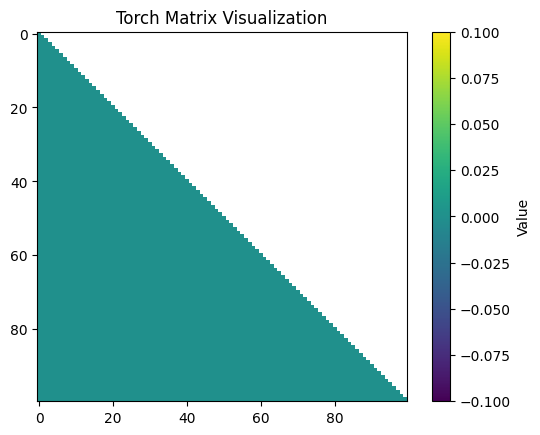

In [18]:
# def create_mask(n_context: int) -> Float[torch.Tensor, "n_context n_context"]:
def create_mask(n_context: int) -> torch.Tensor:
    mask = torch.zeros(n_context, n_context)
    indices = torch.triu_indices(n_context, n_context, offset=1)
    mask[indices[0], indices[1]] = float('-inf')
    
    return mask



# Create a random 5x5 matrix
M = create_mask(100)

# Convert to NumPy for visualization
M_np = M.numpy()

# Plot the matrix
plt.imshow(M_np, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Torch Matrix Visualization")
plt.show()

In [19]:
@dataclass
class GPTConfig:
	d_vocab: int = 10_000
	d_model: int = 128
	d_mlp: int = 512
	n_heads: int = 4
	d_head: int = 32
	n_layers: int = 6
	act_fn: type[nn.Module] = nn.ReLU

# note: the residual stream is `n_context` by `d_model`

# this is the row-wise (last dimension) softmax of x
# F.softmax(x, dim=-1)

class AttentionHead(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.W_Q = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_K = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_O = nn.Linear(cfg.d_head, cfg.d_model) # fix this later
		self.W_V = nn.Linear(cfg.d_model, cfg.d_head)
		

		

	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		#hidden = self.embedding(x)
		# n_context = x.size(0)
		# Q = x @ self.W_Q
		# K = x @ self.W_K
		# V = x @ self.W_V
		# scores = Q @ K.T
		# scores = scores / math.sqrt(Q.size(-1))
		# M = create_mask(n_context).to(x.device)
		# scores = scores + M
		# A = F.softmax(scores, dim=-1)
		# head_output = A @ V
		# return head_output @ self.W_O

		M = create_mask(x.size(0))
  
		return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))
		


class MultiHeadedAttention(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		#List of attention heads
		self.heads = nn.ModuleList([AttentionHead(cfg) for i in range(cfg.n_heads)])

	#def forward(x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		
		for head in range(self.cfg.n_heads):
			x += self.heads[head].forward(x)
		
		return x
        #Each head returns output of shape [n_context, d_head]
        #Concatenate outputs along the feature dimension: [n_context, n_heads * d_head]
        #Project concatenated outputs back to d_model: [n_context, d_model]




class MLP(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		self.Hidden = nn.Linear(cfg.d_model, cfg.d_mlp)
		self.Output = nn.Linear(cfg.d_mlp, cfg.d_model)
		
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.Output(self.Hidden(x))



class Transformer(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
  
		self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)
		self.unembedding = nn.Linear(cfg.d_model, cfg.d_vocab)	

		self.layers = nn.ModuleList(
			nn.ModuleDict({
				'attn': MultiHeadedAttention(cfg),
				'mlp': MLP(cfg)
			}) for _ in range(cfg.n_layers)
		)
  		
		
		# uses `MultiHeadedAttention` and `MLP`
		# uses nn.Embedding for the embedding, transpose of it for the unembedding

	def forward(self, x: Int[torch.Tensor, "n_context"]) -> Float[torch.Tensor, "n_context d_vocab"]:
     
		# x is a sequence of token ids, shape (n_context,)
		# we need to embed it, then pass it through the transformer layers
		# then we need to unembed it
		# the output of the transformer layers is a sequence of vectors, shape (n_context, d_model)
		# the unembedding layer is a linear layer that maps from d_model to d_vocab
		# the output of the unembedding layer is a sequence of logits, shape (n_context, d_vocab)
		# the logits are the output of the model, we return them
  
		x = self.embedding(x) # shape (n_context, d_model)
		
		for layer in self.layers:
			attn_out = layer['attn'](x)
			x += attn_out
			mlp_out = layer['mlp'](x)
			x += mlp_out
		return F.softmax(self.unembedding(x))

In [20]:
cfg = GPTConfig()
#model = Transformer(cfg)
n_context = 10
x = torch.randint(0, cfg.d_vocab, (n_context,))

torch.Size([10])
torch.Size([10, 10000])


C:\Users\shiff\AppData\Local\Temp\ipykernel_27660\3266049027.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))
C:\Users\shiff\AppData\Local\Temp\ipykernel_27660\3266049027.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.unembedding(x))


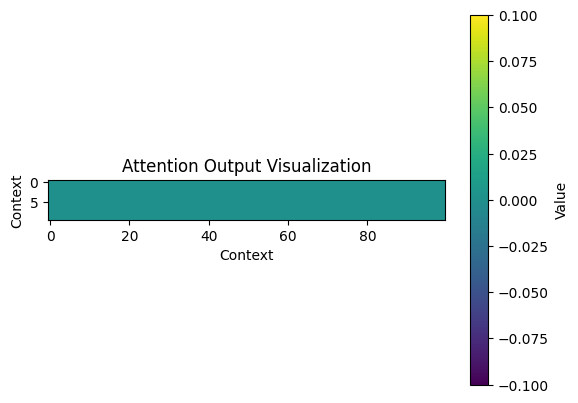

In [21]:
transform = Transformer(cfg)
print(x.shape)
output = transform(x)
print(output.shape)
# print(attn(x))
# print(mh_attn(x))

# visualize the attention scores
plt.imshow(output.detach().numpy()[:, :100], cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores

C:\Users\shiff\AppData\Local\Temp\ipykernel_27660\3266049027.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


torch.Size([10, 128])
torch.Size([10, 128])


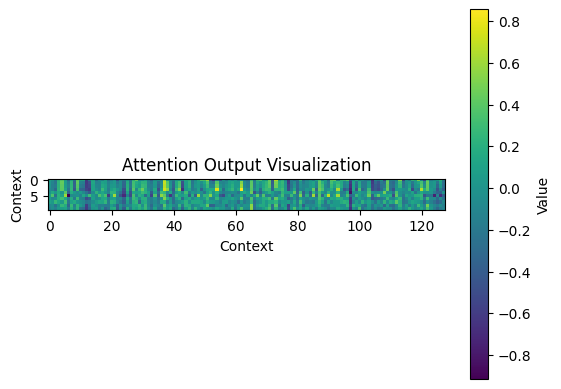

In [22]:
cfg = GPTConfig()

ah = AttentionHead(cfg)
x = torch.randn(10, cfg.d_model)
print(ah(x).shape)

output = ah.forward(x)
print(output.shape)


# visualize the attention scores
plt.imshow(output.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores


In [23]:
from get_books import get_many_books, get_gutenberg_book
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset

book_ids = [84, 85]  

dataset = get_many_books(book_ids, data_temp="./data/gutenberg_data") 


tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Initialize tokenizer once
model_cfg = GPTConfig(d_model=128, d_vocab=tokenizer.vocab_size, n_heads=4, n_layers=6, d_mlp=512)

print(dataset)
print(tokenizer(dataset).shape)




# # Print first book to verify data loading
# print(f"Loaded {len(dataset)} books")
# print("num steps per epoch =", len(dataloader))

# batch_size = 8
# num_epochs = 1
# lr = 1e-3
# weight_decay = 1e-2


Getting book 84...
	426785 characters read
Getting book 84...
	359291 characters read
['\n\n\n\nFrankenstein;\n\n\n\nor, the Modern Prometheus\n\n\n\nby Mary Wollstonecraft (Godwin) Shelley\n\n\n\n\n\n CONTENTS\n\n\n\n Letter 1\n\n Letter 2\n\n Letter 3\n\n Letter 4\n\n Chapter 1\n\n Chapter 2\n\n Chapter 3\n\n Chapter 4\n\n Chapter 5\n\n Chapter 6\n\n Chapter 7\n\n Chapter 8\n\n Chapter 9\n\n Chapter 10\n\n Chapter 11\n\n Chapter 12\n\n Chapter 13\n\n Chapter 14\n\n Chapter 15\n\n Chapter 16\n\n Chapter 17\n\n Chapter 18\n\n Chapter 19\n\n Chapter 20\n\n Chapter 21\n\n Chapter 22\n\n Chapter 23\n\n Chapter 24\n\n\n\n\n\n\n\n\n\nLetter 1\n\n\n\n_To Mrs. Saville, England._\n\n\n\n\n\nSt. Petersburgh, Dec. 11th, 17—.\n\n\n\n\n\nYou will rejoice to hear that no disaster has accompanied the\n\ncommencement of an enterprise which you have regarded with such evil\n\nforebodings. I arrived here yesterday, and my first task is to assure\n\nmy dear sister of my welfare and increasing confidence

Token indices sequence length is longer than the specified maximum sequence length for this model (108225 > 1024). Running this sequence through the model will result in indexing errors


AttributeError: 

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Transformer(cfg)
# model = model.to(device)

# # Set up optimizer and loss
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()

# model.train()
# n_epochs = 2
# print_interval = 10

# for epoch in range(n_epochs):
#     for step, batch in enumerate(dataloader):
#         # [batch_size, seq_len]
#         input_ids_batch = batch['input_ids'].to(device)

#         # We'll accumulate the losses for each sequence in this mini-batch
#         total_loss = 0.0
#         batch_size = input_ids_batch.size(0)

#         # Process each sequence individually
#         for i in range(batch_size):
#             # Extract a single sequence of shape [seq_len]
#             seq_ids = input_ids_batch[i]

#             # Next-token language modeling: input is all but last token, target is all but first
#             inp = seq_ids[:-1]    # shape [seq_len - 1]
#             targ = seq_ids[1:]    # shape [seq_len - 1]

#             # Forward pass
#             # Your model returns logits of shape [seq_len-1, d_vocab]
#             logits = model(inp)

#             # Compute loss across this sequence
#             # CrossEntropyLoss expects [batch, vocab], so we can pass [seq_len-1, d_vocab] vs. [seq_len-1]
#             loss = criterion(logits, targ)

#             # Accumulate
#             total_loss += loss

#         # Average across all sequences in the batch
#         total_loss = total_loss / batch_size

#         # Backprop and update
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#         # Print progress
#         if (step + 1) % print_interval == 0:
#             print(f"Epoch {epoch+1}, Step {step+1}, Loss: {total_loss.item():.4f}")
